<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/Umatilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Umatilla Fire Resilience

#### This notebook demonstrates how Raseter Tools and ancillary data can be used to identify and quantify treatment locations and cost of implementation to reduce fire risk and create fire resilient landscapes. Datasets used in this notebook include raster surfaces created in [Riely et al. 2016](https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1472), roads, streams, water bodies, sawmill locations, [potential operational delineations (PODs)](https://www.fs.usda.gov/research/rmrs/projects/pods), and a digital elevation model.

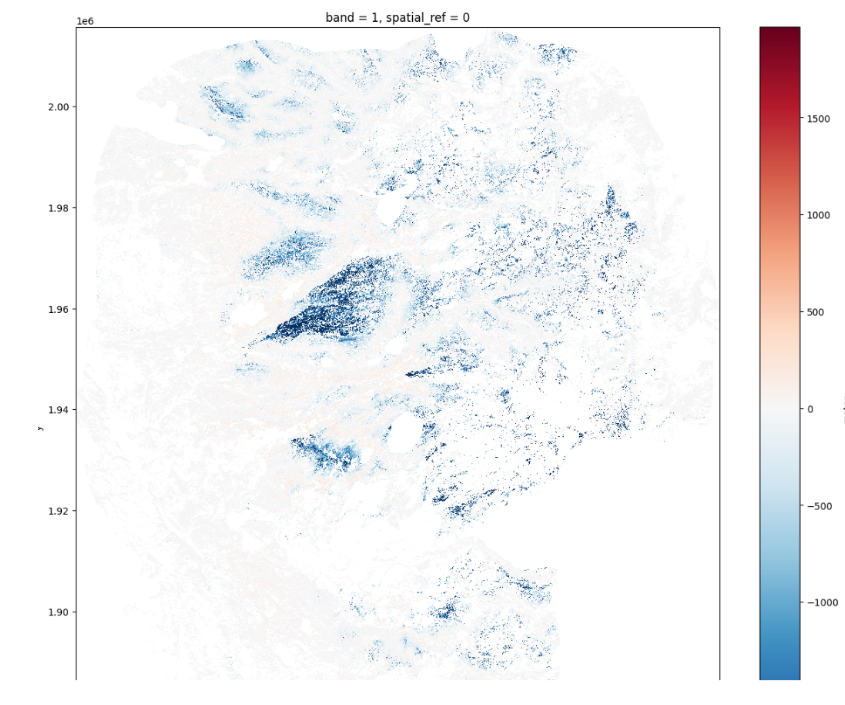

#### Author: John Hogland 4/05/2025

## Overview
#### Using various data sources we will estimate the potential biomass removals and costs associated with transforming the Umatilla National Forest into a more fire resilient landscape. To help navigate these steps the notebook has been split into five sections:
1. Installing software
2. Downloading the data
3. Linking summarized FIA data with tree lists
4. Defining Desired Future Conditions for a fire resilient landscape
5. Quantifying potential costs
6. Linking potential costs with potential removals

#### Step 1: Installing software
##### This step is meant to install Raster Tools and upgrade various packages on [Google's Colab](https://colab.research.google.com/). If working locally and raster tools has already been installed, this step can be skipped.

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install py3dep==0.17.1
!pip install raster_tools
!pip install distributed --upgrade
!pip install rapids --upgrade


#### Step 2: Download the data
We will be using 3 main sources of data for this notebook; the Forest Service Research Data Archive, the Open Street Maps (OSM) project, and USGS 3DEP program. To download the tree data for this notebook run the cell Get Tree list data. After downloading the tree list data and extracting the zipped contents you will have a ".\data" directory containing the raster surfaces created within the [Riely 2016](https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1472) study and supporting crosswalk and tree list tables. While the tree list data covers all of Conus USA, we only need the boundary of the Umatilla's National Forest for our example. Using the Umatilla National Forest boundary extent, we will subset returned polygons from the tree list data and download roads, streams, sawmills, and elevation data. For roads, streams, and sawmill locations we will leverage the Open Street Maps (OSM) project. To download OSM vector datasets run the Get OSM data cell. For elevation data we will download National Elevation Dataset (NED) 30 m DEMs from USGS 3DEP project. To download elevation data run the Get DEM data cell. Finally, to download potential operational delineations, we will extract the polygon POD boundaries from the [National PODs feature service](https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Nat_PODs_Public/FeatureServer).   

#### Files we will be using in this notebook include:
- national_c2016_tree_list = tree list raster
- TL_CN_Lookup = look up table matching TID numbers with Raster values
- Tree_table_Conus = Tree tables in Text format
- OSM roads
- OSM streams
- OSM sawmills
- 3DEP DEM
- POD boundaries
- FIA Species Codes

In [ ]:
from raster_tools import Raster, distance, general, Vector, clipping, surface, creation
import numpy as np, geopandas as gpd, pandas as pd, osmnx as ox, py3dep
import gdown, zipfile, os


In [ ]:
# Get Tree List Data
url='https://usfs-public.box.com/shared/static/yz7h8b8v92scoqfwukjyulokaevzo6v6.zip'#Old link: https://s3-us-west-2.amazonaws.com/fs.usda.rds/RDS-2021-0074/RDS-2021-0074_Data.zip'


outfl = r"C:/Users/jshogland/John/presentation/Authoring/fy2025/AFE/workshop/tree_list_data.zip"

if not os.path.exists(outfl):
    gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

    with zipfile.ZipFile(outfl, "r") as zip_ref:
        zip_ref.extractall(".")


In [ ]:
from shapely.geometry import box

#Get OSM data
national_forest=['Umatilla National Forest, OR']
bnds=[]

sawmill_address='600 NW Cedar St, Pilot Rock, OR 97868'
lat_lon=[]
bdist=0.1

#get the boundary of the national forest from OSM and the location of sawmill
if (len(national_forest)<1):
    snf=gpd.GeoSeries(box(*bnds),crs='EPSG:4326')
else:
    snf=ox.geocode_to_gdf(national_forest).explode() #get each NF boundary as polygon
    acres=snf.to_crs(5070).area * 0.000247105 # Calculate acres
    snf['acres']=acres #assign acres to ploygons
    ch=(acres > 500000) #find the Umatilla boundary based on acres
    snf=snf.iloc[ch.values] #select the Umatilla boundary based on acres

#get the location of the sawmill
if(len(lat_lon)<2):
    sawmill=ox.geocode_to_gdf(sawmill_address,which_result=1).centroid
else:
    sawmill=gpd.GeoSeries(gpd.points_from_xy(x=[lat_lon[1]],y=[lat_lon[0]],crs='EPSG:4326'))

#Create a bounding box to download data
ext=sawmill.union(snf.union_all())
geo=box(*ext.total_bounds).buffer(bdist)

#download road and stream data
roads=ox.features_from_polygon(geo,{'highway':['motorway','trunk','primary','secondary','tertiary','unclassified','residential']})
streams=ox.features_from_polygon(geo,{'waterway':['river','stream','cannel','ditch']})
wbdy=ox.features_from_polygon(geo,{'water':['lake','reservoir','pond']})


In [ ]:
#Get 3Dep data
dem=py3dep.get_dem(geo,resolution=30).expand_dims({'band':1})#add band dimension to the xarray dataset

In [ ]:
#Get FIA Species Codes
url='https://drive.google.com/file/d/1KBK3bpjgKDcpEeuylRo6zxwdSAtyuHCm/view?usp=sharing'
outfl = r"./STF_PODS_2020_V1.zip"
if(not os.path.exists(outfl)):
    gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

    with zipfile.ZipFile(outfl, "r") as zip_ref:
        zip_ref.extractall(".")


In [ ]:
#Get POD data
import requests, shapely

def get_pods(url, geo='',qry='1=1',layer=0):
  '''
  gets a geodataframe from a Feature Service given the url and optionally a bounding geometry and where clause

  url=(string) base url for the feature service
  geo=(object) a bounding box string, shapely polygon, geodataframe, or geoseries. string and shapely polygon objects are assumed to be in the same coordinate system as the feature service
  qry=(string) where clause used to subset the data
  layer= (int) the of the feature service to extract

  return a geodataframe of features
  '''
  s_info=requests.get(url+'?f=pjson').json()
  srn=s_info['spatialReference']['wkid']
  sr='EPSG:'+str(srn)
  if isinstance(geo,gpd.GeoDataFrame):
    geo = (geo.to_crs(sr)).total_bounds
  elif isinstance(geo,gpd.GeoSeries):
    geo = (geo.to_crs(sr)).total_bounds
  elif isinstance(geo,shapely.geometry.Polygon):
    geo = geo.bounds
  else:
    pass
  geo=','.join(np.array(geo).astype(str))
  url1=url+'/'+str(layer)
  l_info=requests.get(url1 + '?f=pjson').json()
  maxrcn=l_info['maxRecordCount']
  if maxrcn>100: maxrcn=100 #used to subset ids so query is not so long
  url2 = url1+'/query?'
  o_info=requests.get(url2,{'where': qry,'geometry':geo,'geometryType': 'esriGeometryEnvelope','returnIdsOnly':'True','f': 'pjson'}).json()
  oid_name=o_info['objectIdFieldName']
  oids=o_info['objectIds']
  numrec=len(oids)
  fslist = []
  for i in range(0, numrec, maxrcn):
    torec = i + (maxrcn-1)
    if torec > numrec:
      torec = numrec

    objectIds = oids[i:torec]
    idstr=oid_name + ' in (' + str(objectIds)[1:-1]+')'
    prm={
        'where': idstr,
        'outFields': '*',
        'returnGeometry': 'true',
        'outSR':srn,
        'f':'pgeojson',
    }
    ftrs=requests.get(url2,prm).json()['features']
    fslist.append(gpd.GeoDataFrame.from_features(ftrs,crs=sr))

  return gpd.pd.concat(fslist)



url = r'https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Nat_PODs_Public/FeatureServer'
pods=get_pods(url,gpd.GeoDataFrame(geometry=[geo],crs=snf.crs),layer=1)

In [ ]:
#Clip tree list data and project other datasets to the same projection as the tree list

tlst=Raster('C:/Users/jshogland/John/presentation/Authoring/fy2025/AFE/workshop/Data/TreeMap2016.tif')

snf_ply=snf.to_crs(tlst.crs)
c_ply=gpd.GeoSeries([geo],crs=snf.crs).to_crs(tlst.crs)

snf_tlst=clipping.clip(clipping.get_vector(c_ply),tlst)
snf_roads=roads.to_crs(tlst.crs).reset_index()
snf_streams=streams.to_crs(tlst.crs).reset_index()
snf_wbdy=wbdy.to_crs(tlst.crs).reset_index()
snf_sawmill=sawmill.to_crs(tlst.crs)
snf_dem=Raster(dem.rio.reproject_match(snf_tlst.xdata))
snf_pods=pods.to_crs(tlst.crs)


In [ ]:
#visualize the projected data
p1=snf_roads.plot(color='gray',figsize=(15,15),zorder=1)
p2=snf_streams.plot(ax=p1, color='lightblue',zorder=2)
p3=snf_wbdy.plot(ax=p2, color='lightblue',zorder=3)
p4=(snf.to_crs(snf_tlst.crs)).plot(ax=p3,edgecolor='red',facecolor='none',linewidth=2,zorder=4)
p5=snf_pods.plot(ax=p4, edgecolor='orange', facecolor='none',zorder=5)
p6=snf_sawmill.plot(ax=p5, color = 'yellow',markersize=50,zorder=6)
p7=snf_dem.plot(ax=p6,cmap='terrain',zorder=0)
p7


#### Step 3: Linking summarized FIA data with tree lists
To link national_c2016_tree_list.tif raster surface to the summarized tree list values we will do the following:
1. Filter Tree_table_CONUS.txt to the TIDs of the clipped c2016_tree_list.tif raster
2. Summarize Tree_table_CONUS.txt by TIDs
3. Reclassify C2016_tree_list.tif to summarized values
4. Save out raster surfaces.

In [ ]:
t_vls,t_cnt=np.unique(snf_tlst,return_counts=True)
tree_tbl=pd.read_csv('C:/Users/jshogland/John/presentation/Authoring/fy2025/AFE/workshop/Data/TreeMap2016_tree_table.csv',sep=',')


In [ ]:
#subset data to values in raster
tree_tbl_sub=tree_tbl[tree_tbl['tm_id'].isin(t_vls)]
rspc=pd.read_csv('REF_SPECIES_jen.csv',delimiter=',').dropna()
usp=np.unique(tree_tbl_sub['SPCD'])
rspc=rspc[rspc['SPCD'].isin(usp)]

#Join Biomass equation coefficients with tree table
tree_tbl_sub=tree_tbl_sub.merge(rspc,on='SPCD')

#calculate basal area ft squared per acre (BAA)
tree_tbl_sub['BAA']=(tree_tbl_sub['DIA']**2)*0.005454*tree_tbl_sub['TPA_UNADJ']

#calculate pounds per acre (AGB)
tree_tbl_sub['AGB']=(np.exp(tree_tbl_sub['JENKINS_TOTAL_B1'] + tree_tbl_sub['JENKINS_TOTAL_B2'] * np.log(tree_tbl_sub['DIA']*2.54))*2.2046)*tree_tbl_sub['TPA_UNADJ']#bone dry pounds per acre

#calculate stem pounds per acre (SAGB)
tree_tbl_sub['SAGB']=(np.exp(tree_tbl_sub['JENKINS_STEM_WOOD_RATIO_B1'] + tree_tbl_sub['JENKINS_STEM_WOOD_RATIO_B2'] / (tree_tbl_sub['DIA']*2.54)))*tree_tbl_sub['AGB']#bone dry pounds per acre

#create needle (n) and broad (b) leaf groups (LTYPE)
tree_tbl_sub['LTYPE']=np.where(tree_tbl_sub['SPCD']<300,"n","b")

#create regen vs merch groups
tree_tbl_sub['MTYPE']=np.where(tree_tbl_sub['DIA']<5,'regen','merch')

#split based on species code (live, dead)
l_tree_tbl_sub = tree_tbl_sub[tree_tbl_sub['STATUSCD']==1]

#summarize by plot and leaf type (LTYPE) and keep BAA TONS
l_tree_sum=(l_tree_tbl_sub.groupby(['tm_id','LTYPE','MTYPE']).sum())[['BAA','TPA_UNADJ','AGB','SAGB']]

#calculate QMD
l_tree_sum['QMD'] = ((l_tree_sum['BAA']/l_tree_sum['TPA_UNADJ'])/0.005454)**0.5

#display the summarized table
display(l_tree_sum)



In [ ]:
plot_nm=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='merch')&(l_tree_sum.index.get_level_values('LTYPE')=='n')]).reset_index(level=[1,2])
plot_bm=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='merch')&(l_tree_sum.index.get_level_values('LTYPE')=='b')]).reset_index(level=[1,2])
plot_nr=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='regen')&(l_tree_sum.index.get_level_values('LTYPE')=='n')]).reset_index(level=[1,2])
plot_br=(l_tree_sum[(l_tree_sum.index.get_level_values('MTYPE')=='regen')&(l_tree_sum.index.get_level_values('LTYPE')=='b')]).reset_index(level=[1,2])
rm_lst=[plot_nm,plot_bm,plot_nr,plot_br]
at_lst=plot_nm.columns[-5:]

print(at_lst)

In [ ]:
#Reclassify tree list raster to various BAA, TPA, AGB, SAGB, and QMD raster surfaces using summarized plot data
rs_lst=[]
for a in at_lst:
    t_lst=[]
    for r in rm_lst:
        rs = snf_tlst.reclassify(r[a].astype('int32').to_dict(),unmapped_to_null=True)
        t_lst.append(rs.where(~rs.to_null_mask(),0)) #set null values to zero and append raster to temp list
    rs_lst.append(general.band_concat(t_lst))

baa,tpa,agb,sagb,qmd=rs_lst #each raster is a 4 band surface with band estimates corresponding to needle leaf merch species, broadleaf  merch specie, needle leaf regen species, broad leaf regen species


#### Step 4: Defining desired future condition (DFC)
DFC are define based on spatial locations as described in **Table 1**.

<h4 style="text-align: Left;">
    <b>Table 1.</b> Criteria used to identify desired future condition (DFC).
</h4>
   
|Feature|Characteristic|Threshold|Desired BAA|
|:-:|:-:|:-:|:-:|
|deferred|Area|NA|Existing BAA|
|Water|Distance From|distance < 100 ft|Existing BAA|
|Water|Distance From|distance > 100 ft|See Aspect Feature|
|Elevation|Slope|slope < 50%|See Aspect Feature|
|Elevation|Slope|slope > 50%|Existing BAA|
|Elevation|Aspect|290<sup>o</sup><Aspect<360<sup>o</sup> or 0<sup>o</sup><Aspect<70<sup>o</sup> |85 ft<sup>2</sup> acre<sup>-1<sup/>|
|Elevation|Aspect|70<sup>o</sup><Aspect<290<sup>o</sup>|65 ft<sup>2</sup> acre<sup>-1<sup/>|
|PODs|Distance From|distance < 2000 ft | 20 ft<sup>2</sup> acre<sup>-1<sup/>|

POD = potential wildland fire operations delineations

In [ ]:
#summarize baa and convert baa (ft sqaured per acre) 
tbaa=general.local_stats(baa,'sum') #baa
tton=(agb/2000)*0.222395 #tons per 30m cell
ston=(sagb/2000)*0.222395 #tons per 30m cell

#create distance surfaces for pods and water
d_pods=distance.pa_proximity(Vector(snf_pods.boundary).to_raster(snf_dem))
s_rs=Vector(snf_streams).to_raster(snf_dem)
w_rs=Vector(snf_wbdy).to_raster(snf_dem)
d_water=distance.pa_proximity(w_rs.where(~w_rs.to_null_mask(),s_rs))

#create slope and aspect surfaces
slp_rs=surface.slope(snf_dem,False)
asp_rs=surface.aspect(snf_dem)

#create dfc baa
ach=((asp_rs<360) & (asp_rs>290)) | ((asp_rs<70) & (asp_rs>0))
asp_baa=(ach * 85).where(ach,65)
dch=d_pods<610 #2000 ft
p_baa= asp_baa
t1=p_baa.where((slp_rs<0.5),tbaa)
t2=(dch*20).where(dch,t1)
dfc=t2.where(d_water>30.48,tbaa) #100 ft

#calc removals to meet DFC
rem_rs = tbaa-dfc
rem_rs = rem_rs.where((rem_rs > 0),0)

#calc % removed Baa and estimate AGB removed to meet DFC (tons)
pr_baa=rem_rs/tbaa
ton_rm=general.local_stats(tton,'sum') * pr_baa
ston_rm=general.local_stats(ston.get_bands([1,2]),'sum')*pr_baa

#### Step 5: Quantifying potential costs
The potential costs methodology estimate the costs of removing biomass on per ton basis using machine rates and spatial analyses. Transportation costs are estimated using OSM roads segments, the rate of travel presented in **Table 2**, and log truck machine rates presented in **Table 3**. Extraction costs are estimated using **Table 3** machine rates. The potential treatment cost estimation approach is described in detail in [Hogland et. al. 2018](https://www.mdpi.com/2220-9964/7/4/156) and [2021](https://www.mdpi.com/1999-4907/12/8/1084).

**Table 2**. Road segment travel speed by [OSM highway](https://wiki.openstreetmap.org/wiki/Key:highway) class types.

|Query|Speed (MPH)|
|:-|:-:|
|Residential|25|
|Unclassified|15|
|Tertiary|35|
|Secondary|45|
|Primary|55|
|Trunk|55|
|Motorway|65|

**Table 3**. Criteria used to spatially define harvesting systems and treatment costs. Machine rate of travel, and capacity estimates derived from meetings with Lisa Ball, Jacob Baker, Michael Jow, and Brian McCrory. Tons = bone dry.

|Component|System|Rate|Rate of travel|Payload|Where it can occur|
|:-:|:-:|:-:|:-:|:-:|:-:|
|       |Rubber tire skidder|\$165/hr|1.5 MPH|1.5 Tons|Slopes <= 35% and Next to Roads ( distance < 1510 ft from a road).|
|Offroad|Skyline|\$400/hr|2.0 MPH|1.25 Tons|Slopes > 35% and within 1000 ft of a road.|
|       |Helicopter|\$8,000/hr|2.4 MPH|2 Tons|Areas not covered by the other two and distance < 3000 ft from landing area.|
|Felling|Feller buncher|\$14.80/Ton|NA|NA|Slopes <= 35%|
|       |Hand Felling|\$26.67/Ton|NA|NA|Slopes > 35%|
|Processing|Delimbing, cutting to length, chipping, and loading|\$50.11/Ton|NA|NA|NA|
|On road|Log Truck|\$98/hour|Table 1|13 Tons|NA|
|Additional Treatments|Hand Treatment|\$0/acre|NA|NA|Forested Areas|
|       |Prescribed fire|\$210/acre|NA|NA|Forested Areas|

In [ ]:
h_speed={'residential':40,'unclassified':24,'tertiary':56,'secondary':72,'primary':88,'trunk':88,'motorway':105} #kph units in meters

#offroad rates of travel kph units in meters
sk_r=2.4
cb_r=3.2
hl_r=3.8

#component rates $ per hour or unit area
sk_d=165
cb_d=400
hl_d=8000
fb_d=14.80
hf_d=26.67
pr_d=50.11
lt_d=98
ht_d=0
pf_d=210

#payloads ton
sk_p=1.5
cb_p=1.25
hl_p=2
lt_p=13

#set speed for road segments
snf_roads['speed']=snf_roads['highway'].map(h_speed)
tms=snf_roads.maxspeed.str.slice(0,2)
snf_roads['speed'].where(snf_roads['maxspeed'].isna(),tms)
snf_roads['conv']=2*(((1/(snf_roads['speed']*1000))*lt_d)/lt_p) #1000 converts kilometers per hour to meters per hour

#snap sawmill facility to road vertices
print("Snapping sawmills to roads")
smill_b=gpd.GeoDataFrame(geometry=sawmill).to_crs(snf_dem.crs)
tmp_rds=snf_roads
tmp_rds_seg=tmp_rds.sindex.nearest(smill_b.geometry,return_all=False)[1]
lns=tmp_rds.iloc[tmp_rds_seg].geometry.values
smill_b['cline']=lns
smill_b['npt']=smill_b.apply(lambda row: row['cline'].interpolate(row['cline'].project(row['geometry'].centroid)),axis=1)#, result_type = 'expand')
saw=Vector(smill_b.set_geometry('npt').set_crs(smill_b.crs))

#create barriers to off road skidding
bar2=(d_water>0).set_null_value(0)


# create slope and road distance surfaces
print("Creating base layers to threshold")
slp = slp_rs.eval() #compute so that slope only needs to be calculated once
c_rs = creation.constant_raster(snf_dem).set_null_value(0) #constant value of 1 to multiply by distance
rds_rs = (Vector(snf_roads).to_raster(snf_dem,'conv').set_null_value(0)) #source surface with all non-road cells (value of zero) set to null


# convert on road rates and payload into on road cost surface that can be multiplied by the surface distance along a roadway to estimate hauling costs
print("Calculating on road hauling costs")
saw_rs=(saw.to_raster(snf_dem).set_null_value(0))
on_d_saw = distance.cda_cost_distance(rds_rs,saw_rs,snf_dem)

# convert onroad surfaces to source surfaces measured in cents / ton
src_saw = (on_d_saw * 100).astype(int)



In [ ]:
# create offroad surface distance surfaces that can be muliplied by rates to estimate dollars per unit
print("Calculating offroad costs")

#barriers to motion
b_dst_cs2=bar2#.set_null_value(0) # skidding and cable

#calc distance
saw_d,saw_t,saw_a=distance.cost_distance_analysis(b_dst_cs2,src_saw,snf_dem)
saw_d=saw_d.where(saw_d>0,np.nan)
saw_d=saw_d.where(saw_a>0,np.nan)

# Onroad, offroad, Felling, processing costs, and Additional Treatments
print("Calculating additional felling, processing, and treatment costs")
f1=slp<=0.35
fell=(f1*fb_d).where(f1,hf_d)
prc=creation.constant_raster(snf_dem,pr_d).astype(float)
oc=fell+prc

#Additional treatment costs (per/ha)
ht_cost=creation.constant_raster(snf_dem,(ht_d*0.222395)).astype(float) #0.222395 acres per cell
pf_cost=creation.constant_raster(snf_dem,(pf_d*0.222395)).astype(float) #0.222395 per cell
#add_treat_cost=a_t*frst

# Convert offroad rates to a mulitiplier that can be used to calculate dollars per ton given distance
print("Combining costs...")
s_c= (2 * (((1/(sk_r*1000))*sk_d)/sk_p))
c_c= (2 * (((1/(cb_r*1000))*cb_d)/cb_p))
h_c= (2 * (((1/(hl_r*1000))*hl_d)/hl_p))

# Calculate potential saw costs $/Ton
sk_saw_cost=(saw_d * s_c) + oc
cb_saw_cost=(saw_d * c_c) + oc
hd_saw_cost=(saw_d * h_c) + oc

# Operations
rd_dist=distance.cda_cost_distance(c_rs,(rds_rs>0).astype(int),snf_dem)

sk=f1 & (rd_dist<460)
cb=((slp>0.35) & (rd_dist<305))*2
skcb=sk+cb
opr=(skcb.where(skcb>0,3) * (rd_dist<915)).astype(float)

#Create final rasters
o1=opr==1
o2=opr==2
o3=opr==3
sc1=sk_saw_cost*o1
sc2=cb_saw_cost*o2
sc3=hd_saw_cost*o3

# Calculate potential haul cost allocated $/Ton
phaul=(saw_a/100)
phaul=phaul.where(opr>0,0)

saw_cost=sc1+sc2+sc3 #total cost $/ton to remove material

add_tr_fr_cost=ht_cost+pf_cost #additional cost to implement prescribed burning and hand treatments
add_tr_fr_cost=add_tr_fr_cost.where(opr>0,0)


#### Step 6: Linking potential cost with potential removals

#### Defining potential treatment units
While DFC may not be in alignment with our current condition at the cell level, one cell alone may not be worth the time and effort to setup and implement a operational treatment unit. Likewise, the difference between DFC and the existing condition may be so close at the cell level that a treatment is unwarranted. To identify operational treatment areas that meet both conditions (enough biomass and a large enough region) we will select all cells that have at least 3 tons of biomass needed to be removed and that when combined into a region of cells meeting that criteria account for at least 12 acres.  

In [ ]:
#potential treatment units
rgns=general.regions((ton_rm>3).astype('int32'),neighbors=4,unique_values=[1]).set_null_value(0) #find unique region
vls, cnts=np.unique(rgns,return_counts=True) # summarize counts by each region
df=pd.DataFrame({'regions':vls,'counts':cnts}) #convert to dataframe
r_m_c=df[(df['counts']>55) & (df['regions']>0)] #select regions with counts greater than 55 (skip region 0, it is the background)
rdic=r_m_c.reset_index().set_index('regions')['index'].to_dict() #convert to dictionary for remapping
ptu=rgns.reclassify(rdic,True) # reclassify region map to index values for regions meeting criteria (potential treatment units; ptu)

#### Estimate potential cost, revenue, and profite at the cell level and summarize up to the treatment level ($110/ton bone dry)

In [ ]:
from raster_tools import zonal
#potential cost
pcost=ton_rm*saw_cost + ston_rm * phaul + add_tr_fr_cost# 
prev=ston_rm*130#using $65/ton for gate prices


#### Summarize potential costs using potential treatment units

In [ ]:
#convert ptu to polygons
v_regions=ptu.to_polygons().compute()

In [ ]:
#use zonal statistics to summarize cell values within each polygon
st2=zonal.zonal_stats(v_regions,general.band_concat([pcost,prev,ton_rm,ston_rm]),'sum',features_field='value',wide_format=True)# 
st2=st2.compute()
st2.columns= ['cost','revenue','ttons','stons'] #remove the 2 level index to merger data back to v_regions
v_regions=v_regions.merge(st2,left_on='value',right_on='zone')
v_regions['acres']=v_regions.area*0.000247105
v_regions['ttons_acre']=v_regions['ttons']/v_regions['acres']
v_regions['stons_acre']=v_regions['stons']/v_regions['acres']
v_regions['cost_acre']=v_regions['cost']/v_regions['acres']
v_regions['revenue_acre']=v_regions['revenue']/v_regions['acres']
v_regions['cost_ton']=v_regions['cost']/v_regions['ttons']
v_regions['revenue_ton']=v_regions['revenue']/v_regions['ttons']

In [ ]:
csdif=-1 #per ton
chk=((v_regions.cost_ton > 0) & ((v_regions.revenue_ton-v_regions.cost_ton)>csdif)) #cost per acre $25
vsub=v_regions[chk]
print('Total acres treated =',vsub.acres.sum(),'Total profit =', (vsub.revenue-vsub.cost).sum(), 'Total tons removed =',vsub.ttons.sum(), 'Total tons delivered =',vsub.stons.sum())

In [ ]:

m=vsub.explore(column='stons_acre')
m=snf_sawmill.explore(m=m,color='red')
m

In [ ]:
v_regions.describe()

#### Display the results

In [ ]:
import folium

display(v_regions)

m=(snf.to_crs(snf_tlst.crs)).explore(color='red',name='NF Boundary')
m=snf_pods.explore(m=m, color='orange',name='PODs')
m=snf_sawmill.explore(m=m, color = 'yellow',name='Sawmill')
m=v_regions.explore(m=m,column='band_3_sum',legend=True,cmap='RdYlGn',name='Potential Units')

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)

ton_rm.explore(band=1,cmap='PRGn',map=m, name='Ton Removed')
folium.LayerControl().add_to(m)

m

In [ ]:
m.save('Umatilla_NF.html')

# This ends the Fire Resilence notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/README.md
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html